In [1]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scienceplots

plt.style.use('science')

FOLDER = "20250427"
ASSETS = "../assets/"+FOLDER+"/"
INPUT = "../input/"+FOLDER+"/"
OUTPUT = "../output/"+FOLDER+"/"

LINE_COLOR='#1B4244'



In [30]:
import pandas as pd
import json

def download_from_blockchainapi(name):
    """
    Download a CSV file from BlockchainAPI and save it to the specified filename.
    """
    filename = INPUT+name + ".json"    
    response = requests.get(f"https://api.blockchain.info/charts/{name}?timespan=10000weeks&rollingAverage=8hours&format=json")
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {filename}. Status code: {response.status_code}")


download_from_blockchainapi('hash-rate')
download_from_blockchainapi('market-price')
download_from_blockchainapi('total-bitcoins')
download_from_blockchainapi('transaction-fees')


Downloaded ../input/20250427/hash-rate.json
Downloaded ../input/20250427/market-price.json
Downloaded ../input/20250427/total-bitcoins.json
Downloaded ../input/20250427/transaction-fees.json


In [31]:

# Load the JSON data from the provided file path
file_path = INPUT+'hash-rate.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract hash-rate and market-price data
hash_rate_data = data['values']

# Load the JSON data from the provided file path
file_path = INPUT+'market-price.json'
with open(file_path, 'r') as file:
    data = json.load(file)

market_price_data = data['values']

# Create separate DataFrames for hash-rate and market-price
hash_rate_df = pd.DataFrame(hash_rate_data)
market_price_df = pd.DataFrame(market_price_data)

# Rename columns for clarity
hash_rate_df.columns = ['timestamp', 'hash_rate']
market_price_df.columns = ['timestamp', 'market_price']

# Convert timestamp to datetime format
hash_rate_df['timestamp'] = pd.to_datetime(hash_rate_df['timestamp'], unit='s')
market_price_df['timestamp'] = pd.to_datetime(market_price_df['timestamp'], unit='s')

# Merge the two DataFrames on timestamp
merged_df = pd.merge(hash_rate_df, market_price_df, on='timestamp', how='outer')


In [32]:
market_price_df

,timestamp,market_price
0,2009-01-03,0.00
1,2009-01-07,0.00
2,2009-01-11,0.00
3,2009-01-15,0.00
4,2009-01-19,0.00
...,...,...
1485,2025-04-09,76266.57
1486,2025-04-13,85283.27
1487,2025-04-17,84033.59
1488,2025-04-21,85172.64


In [33]:
# Load the JSON data from the new provided file path
file_path_total_bitcoins = INPUT+'total-bitcoins.json'
with open(file_path_total_bitcoins, 'r') as file:
    data_total_bitcoins = json.load(file)

# Extract total-bitcoins and market-price data
total_bitcoins_data = data_total_bitcoins['values']

# Create separate DataFrames for total-bitcoins and market-price
total_bitcoins_df = pd.DataFrame(total_bitcoins_data)

# Rename columns for clarity
total_bitcoins_df.columns = ['timestamp', 'total_bitcoins']

# Convert timestamp to datetime format
total_bitcoins_df['timestamp'] = pd.to_datetime(total_bitcoins_df['timestamp'], unit='s')


In [34]:
# Load the JSON data from the new provided file path
file_path_tran_fee = INPUT+'transaction-fees.json'
with open(file_path_tran_fee, 'r') as file:
    data_tran_fee = json.load(file)

# Extract total-bitcoins and market-price data
tran_fee_data = data_tran_fee['values']

# Create separate DataFrames for total-bitcoins and market-price
tran_fee_df = pd.DataFrame(tran_fee_data)

# Rename columns for clarity
tran_fee_df.columns = ['timestamp', 'daily_transaction_fees']

# Convert timestamp to datetime format
tran_fee_df['timestamp'] = pd.to_datetime(tran_fee_df['timestamp'], unit='s')
tran_fee_df.set_index('timestamp', inplace=True)

C:\Users\pkapl\AppData\Local\Temp\ipykernel_18624\1867475990.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


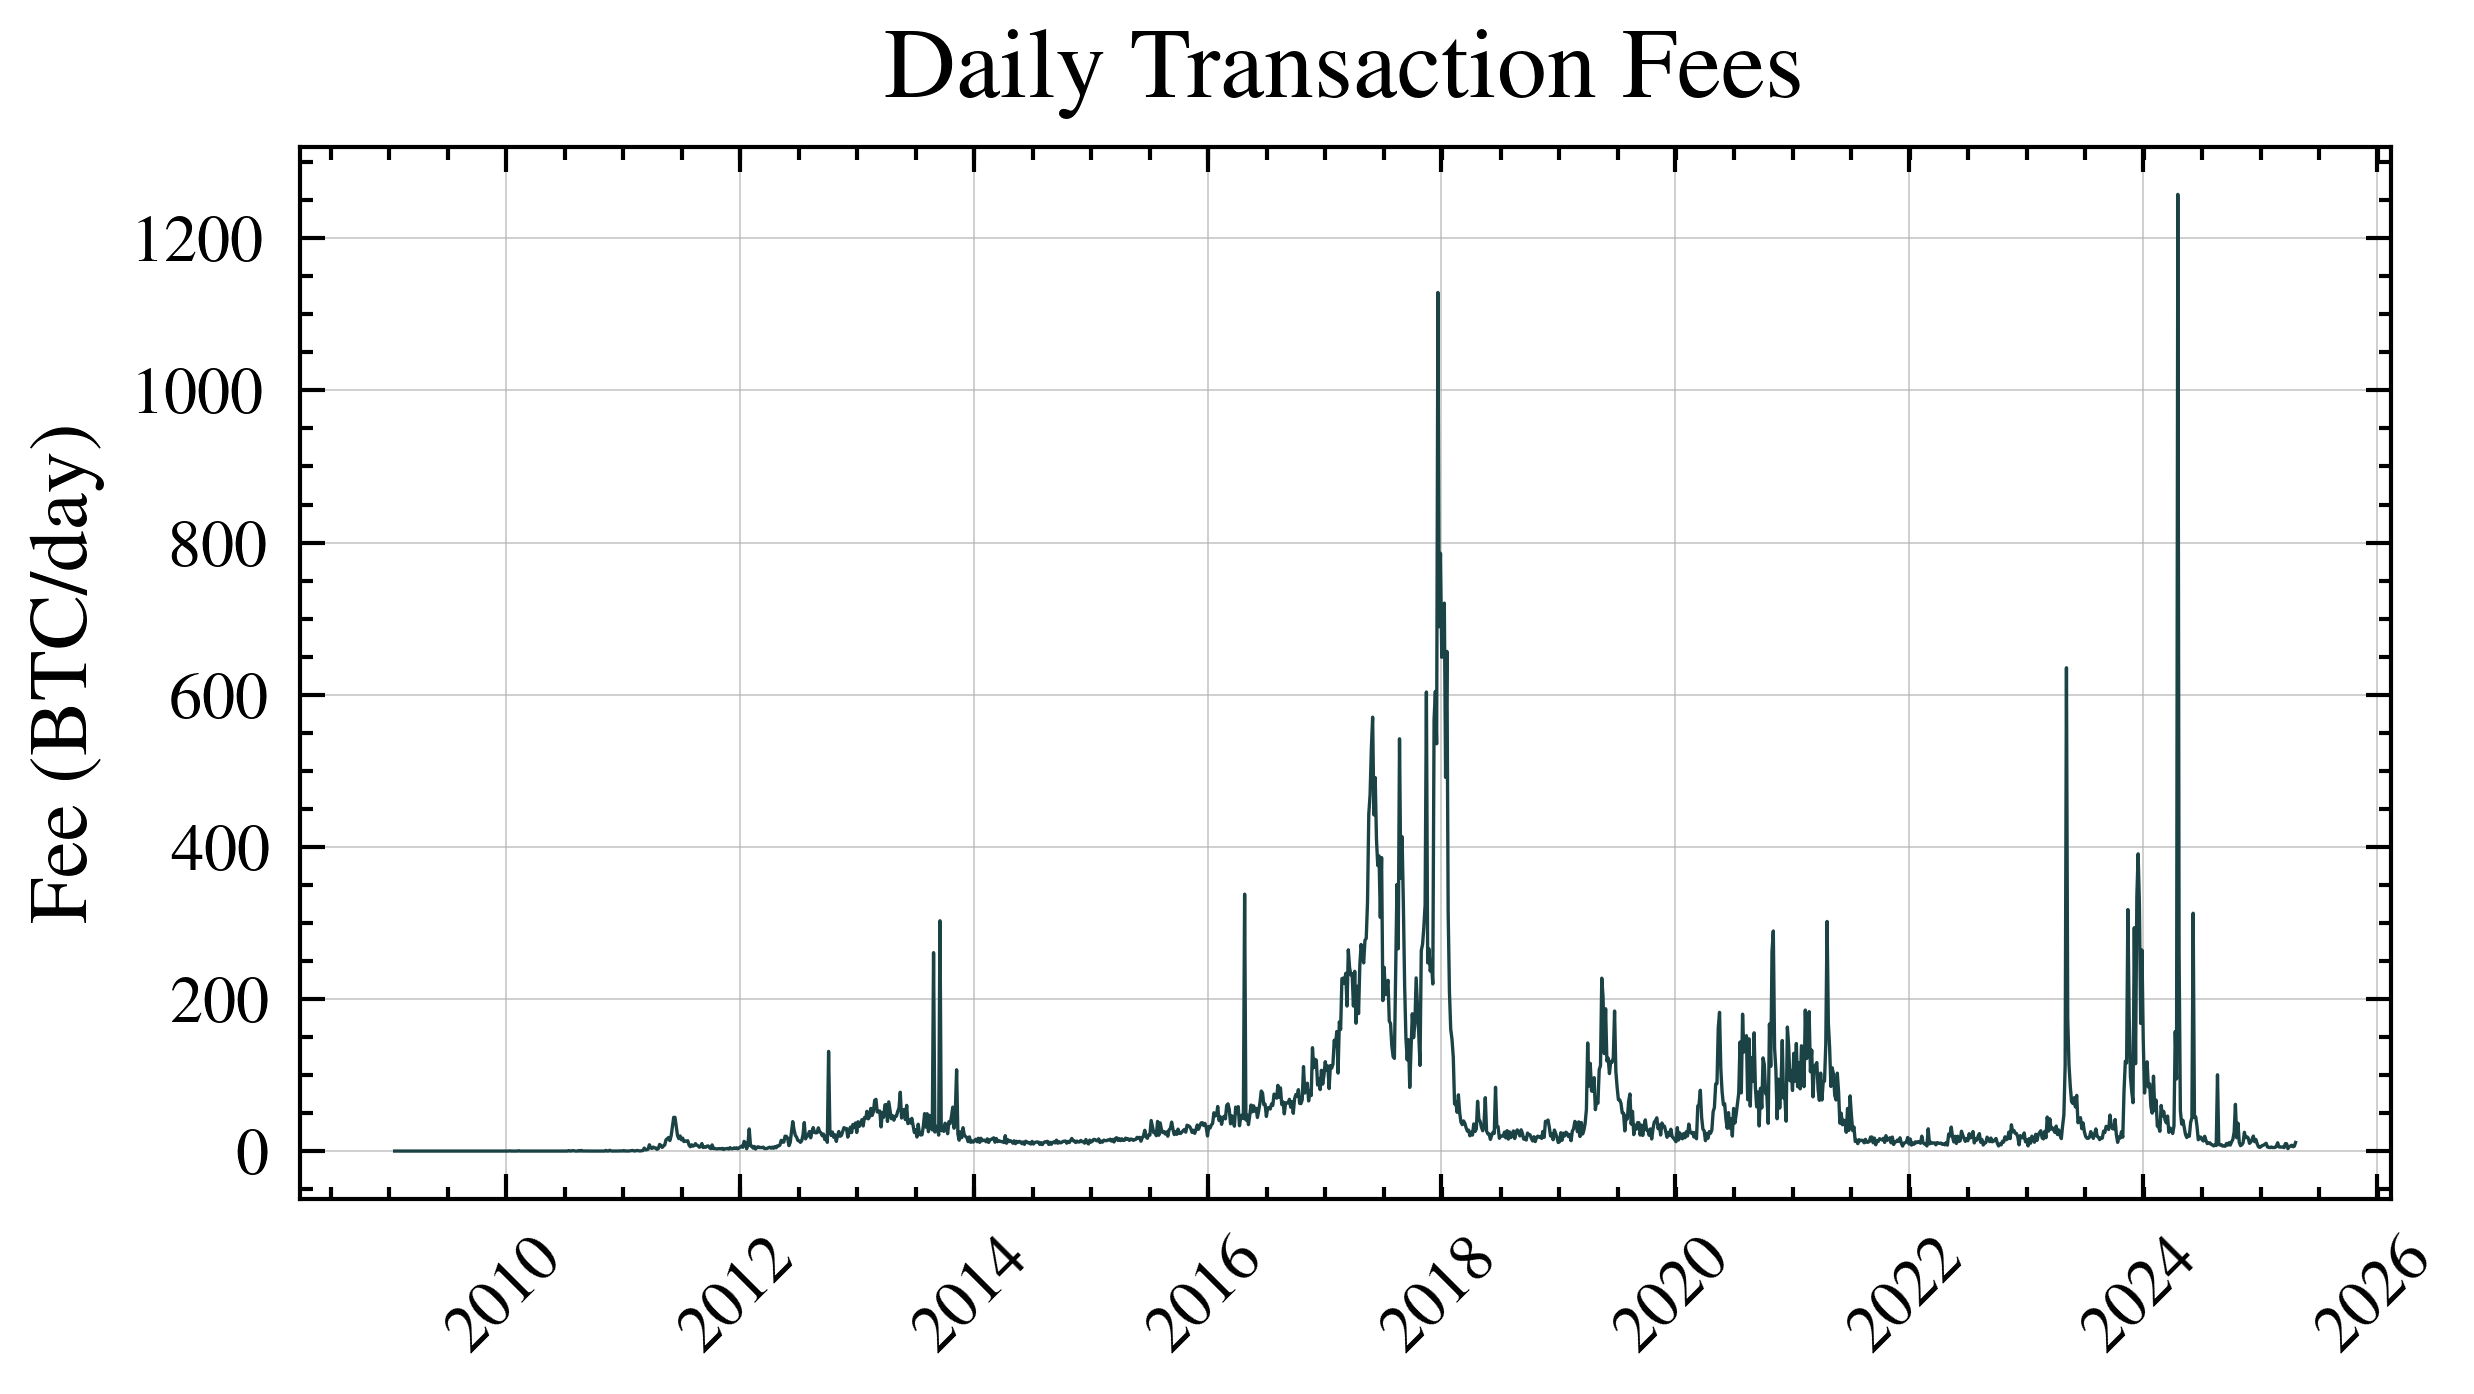

In [35]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(tran_fee_df.index, tran_fee_df["daily_transaction_fees"],color=LINE_COLOR, linewidth=0.4)
    plt.title('Daily Transaction Fees', fontsize=12)
    plt.ylabel('Fee (BTC/day)', fontsize=10)
    plt.legend()
    plt.savefig(ASSETS+'transactionfees1.png')
    plt.show()

In [37]:
merged_df.set_index('timestamp', inplace=True)
total_bitcoins_df.set_index('timestamp', inplace=True)
merged_df= merged_df.resample('W-SUN').last()
total_bitcoins_df=total_bitcoins_df.resample('W-SUN').last()
tran_fee_df=tran_fee_df.resample('D').ffill().resample('W-SUN').last()

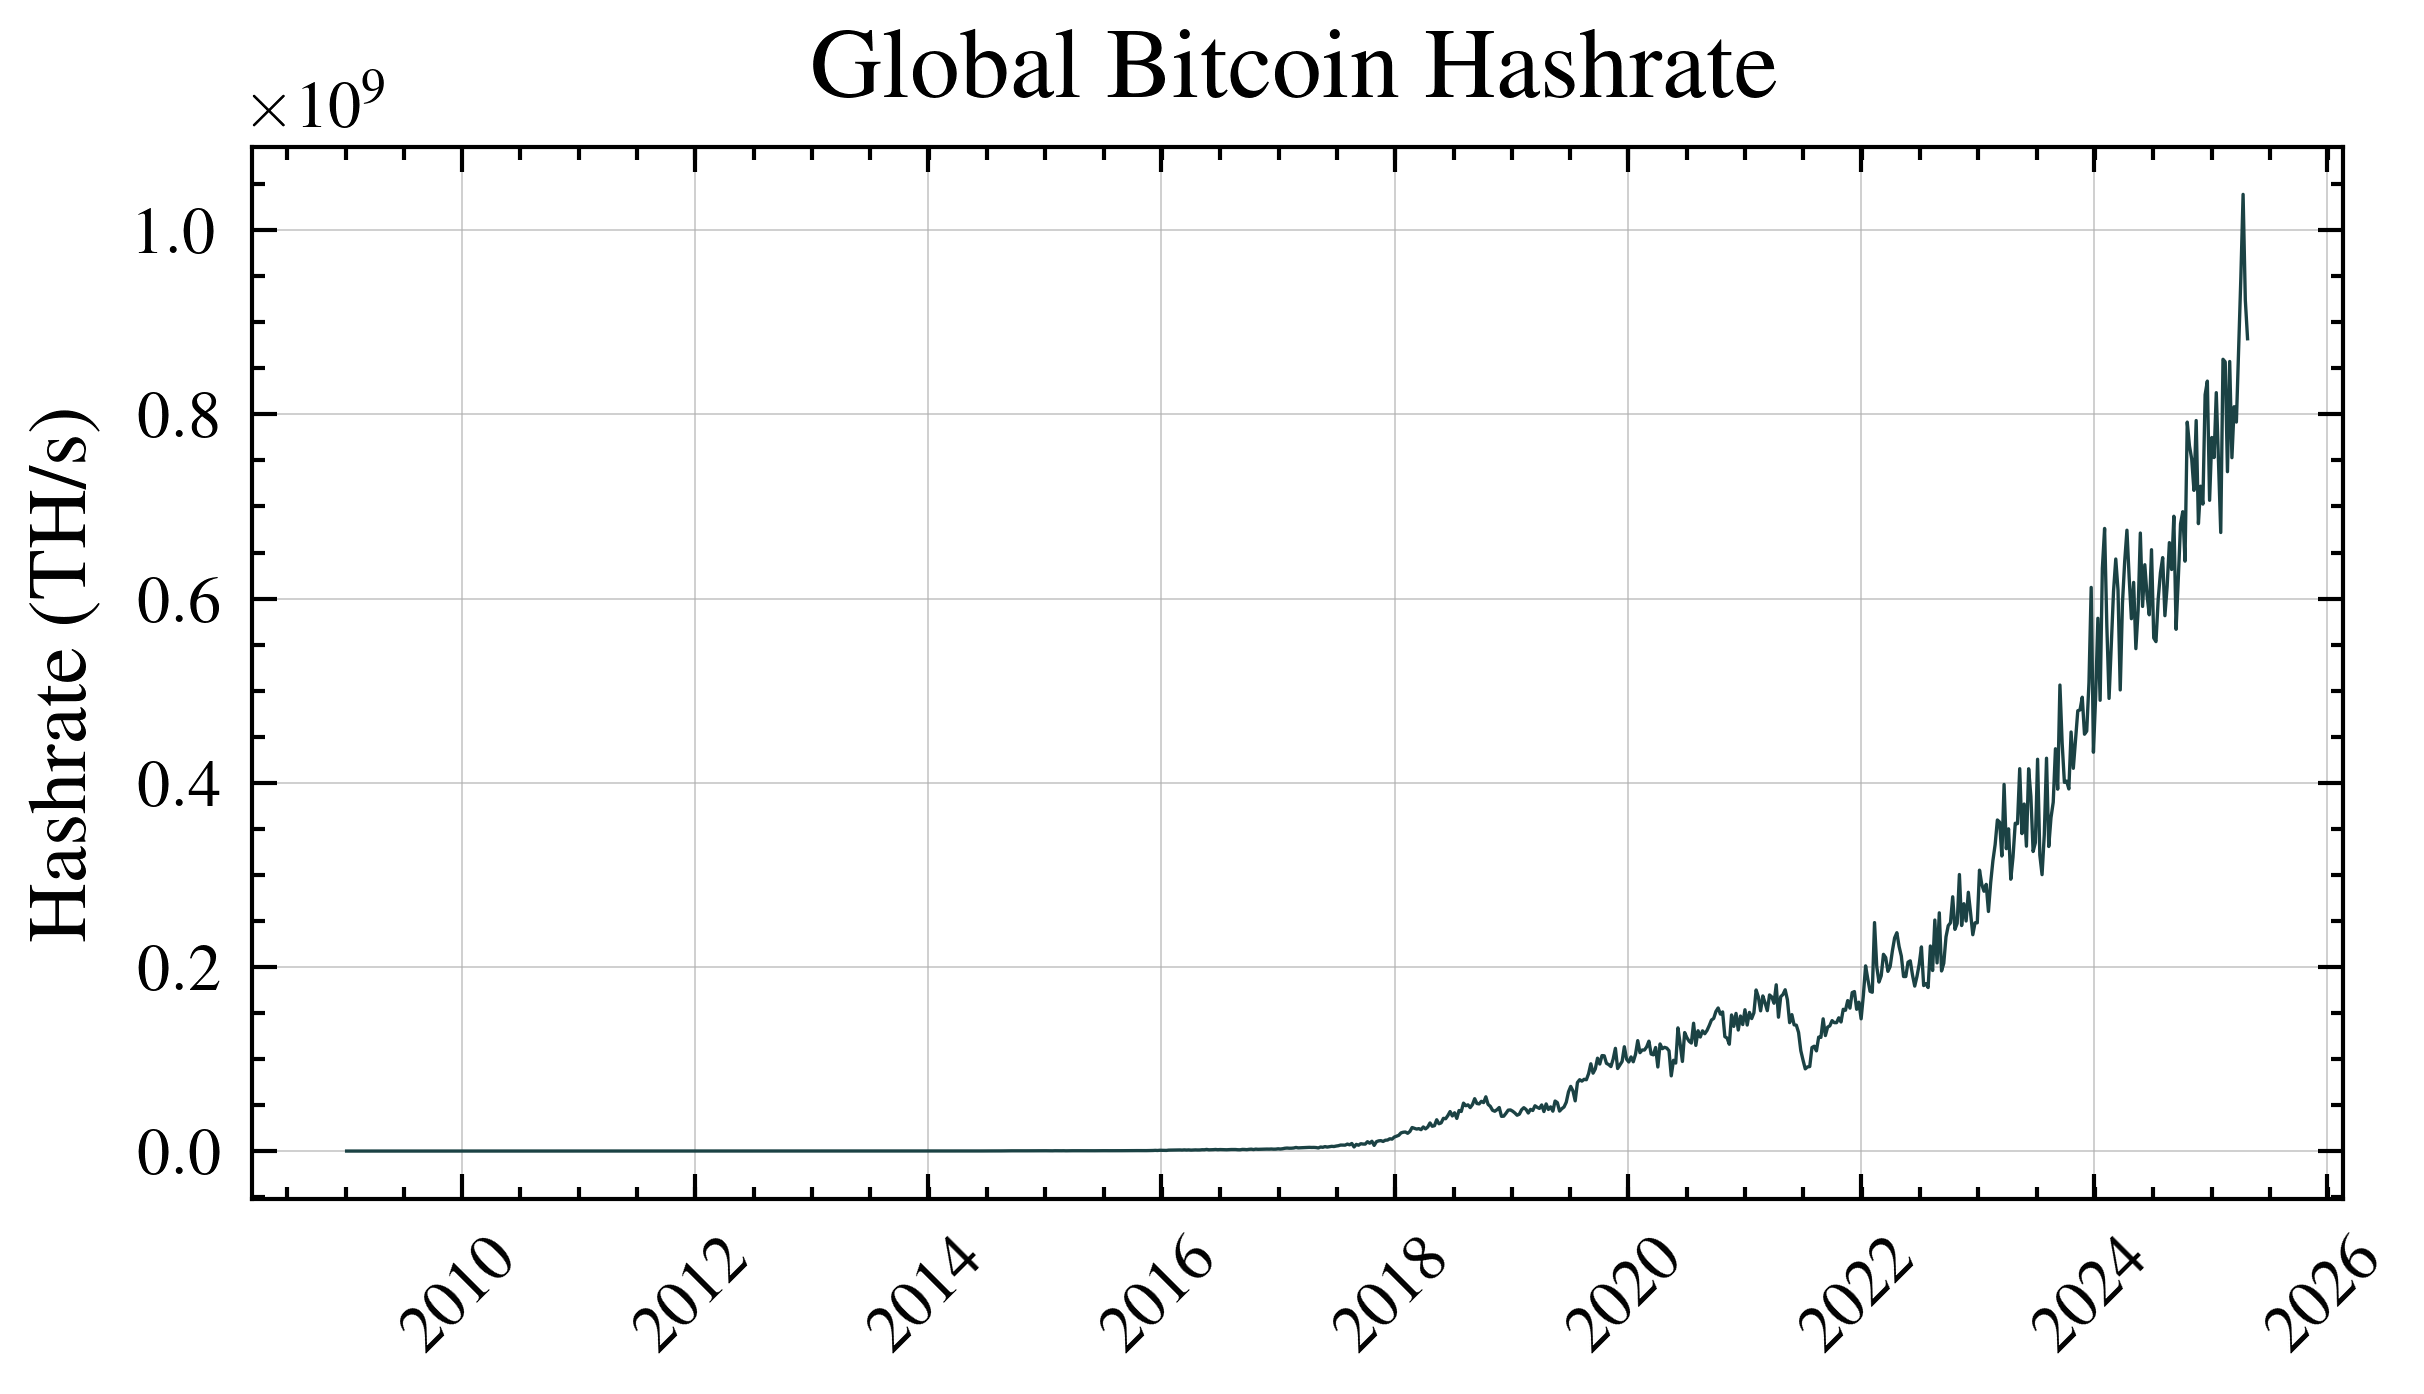

In [39]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(merged_df["hash_rate"].index, merged_df["hash_rate"],color=LINE_COLOR, linewidth=0.4)
    plt.title('Global Bitcoin Hashrate', fontsize=12)
    plt.ylabel('Hashrate (TH/s)', fontsize=10)
    plt.savefig(ASSETS+'hashrate1.png')
    plt.show()

In [40]:
# prompt: merge merged_df and total_bitcoins_df

onchain_df = pd.merge(merged_df,tran_fee_df, left_index=True, right_index=True, how='inner')
onchain_df.to_csv(OUTPUT+'onchain.csv')

In [41]:
import pandas as pd

def create_btc_time_series():
    # Define the data as lists
    years = [
        '2009-01-03', '2012-11-28', '2016-06-09', '2020-05-11', '2024-04-20', '2028-06-01', '2032-06-01', '2036-06-01', 
        '2040-06-01', '2044-06-01', '2048-06-01', '2052-06-01', '2056-06-01', '2060-06-01', '2064-06-01', '2068-06-01', 
        '2072-06-01', '2076-06-01', '2080-06-01', '2084-06-01', '2088-06-01', '2092-06-01', '2096-06-01', '2100-06-01', 
        '2104-06-01', '2108-06-01', '2112-06-01', '2116-06-01', '2120-06-01', '2124-06-01', '2128-06-01', '2132-06-01', 
        '2136-06-01', '2140-06-01'
    ]

    block_reward = [
        50, 25, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125,
        0.09765625, 0.048828125, 0.024414063, 0.012207031, 0.006103516,
        0.003051758, 0.001525879, 0.000762939, 0.00038147, 0.000190735,
        0.000095367, 0.000047684, 0.000023842, 0.000011921, 0.00000596,
        0.00000298, 0.00000149, 0.00000075, 0.00000037, 0.00000019,
        0.00000009, 0.00000005, 0.00000002, 0.00000001, 0.00000001
    ]

    total_btc_mined = [
        0, 10500000, 15750000, 18375000, 19687500, 20343750, 20671875,
        20835937.5, 20917968.75, 20958984.375, 20979492.1875, 20989746.09375,
        20994873.046875, 20997436.5234375, 20998718.26171875, 20999359.130859375,
        20999679.565429688, 20999839.782714844, 20999919.891357422,
        20999959.945678711, 20999979.972839355, 20999989.986419678,
        20999994.993209839, 20999997.496604919, 20999998.74830246,
        20999999.37415123, 20999999.687075615, 20999999.843537807,
        20999999.921768904, 20999999.960884452, 20999999.980442226,
        20999999.990221113, 20999999.995110556, 21000000
    ]

    new_btc_mined = [
        0, 10500000, 5250000, 2625000, 1312500, 656250, 328125, 164062.5,
        82031.25, 41015.625, 20507.8125, 10253.90625, 5126.953125,
        2563.4765625, 1281.73828125, 640.869140625, 320.4345703125,
        160.21728515625, 80.108642578125, 40.0543212890625, 20.02716064453125,
        10.013580322265625, 5.0067901611328125, 2.5033950805664062,
        1.2516975402832031, 0.6258487701416016, 0.3129243850708008,
        0.1564621925354004, 0.0782310962677002, 0.0391155481338501,
        0.01955777406692505, 0.009778887033462525, 0.0048894435167312625,
        0.0048894435167312625
    ]

    pct_all_btc_mined = [
        "0.00%", "50.00%", "75.00%", "87.50%", "93.75%", "96.88%", "98.44%",
        "99.22%", "99.61%", "99.80%", "99.90%", "99.95%", "99.98%", "99.99%",
        "99.994%", "99.997%", "99.998%", "99.999%", "99.9996%", "99.9998%",
        "99.9999%", "99.99995%", "99.99998%", "99.99999%", "99.999994%",
        "99.999997%", "99.999999%", "99.9999993%", "99.9999996%",
        "99.9999998%", "99.9999999%", "99.99999995%", "99.99999998%", "100.00%"
    ]

    # Create a DataFrame from the data
    df = pd.DataFrame({
        'Year': years,
        'Block Reward': block_reward,
        'Total BTC Mined': total_btc_mined,
        'New BTC Mined': new_btc_mined,
        '% of All BTC Mined': pct_all_btc_mined
    })

    # Convert the 'Year' column to a datetime column representing January 1 of that year
    df['Date'] = pd.to_datetime(df['Year'])

    # Set the datetime column as the index and drop the 'Year' column if desired
    df.set_index('Date', inplace=True)
    df.drop(columns='Year', inplace=True)

    return df

In [42]:
sim_btc = create_btc_time_series()
sim_btc

,Block Reward,Total BTC Mined,New BTC Mined,% of All BTC Mined
Date,,,,
2009-01-03,5.000000e+01,0.000000e+00,0.000000e+00,0.00%
2012-11-28,2.500000e+01,1.050000e+07,1.050000e+07,50.00%
2016-06-09,1.250000e+01,1.575000e+07,5.250000e+06,75.00%
2020-05-11,6.250000e+00,1.837500e+07,2.625000e+06,87.50%
2024-04-20,3.125000e+00,1.968750e+07,1.312500e+06,93.75%
2028-06-01,1.562500e+00,2.034375e+07,6.562500e+05,96.88%
2032-06-01,7.812500e-01,2.067188e+07,3.281250e+05,98.44%
2036-06-01,3.906250e-01,2.083594e+07,1.640625e+05,99.22%
2040-06-01,1.953125e-01,2.091797e+07,8.203125e+04,99.61%


In [ ]:
sim_btc_res= sim_btc[['Total BTC Mined']].resample('D').interpolate(method='linear').resample('W-SUN').mean()

In [44]:
sim_btc_res.rename(columns={'Total BTC Mined':'total_bitcoins'}).to_csv(OUTPUT+'simulated_bitcoins.csv')
sim_btc.rename(columns={'Total BTC Mined':'total_bitcoins'}).to_csv(OUTPUT+'simulated_bitcoins_lores.csv')

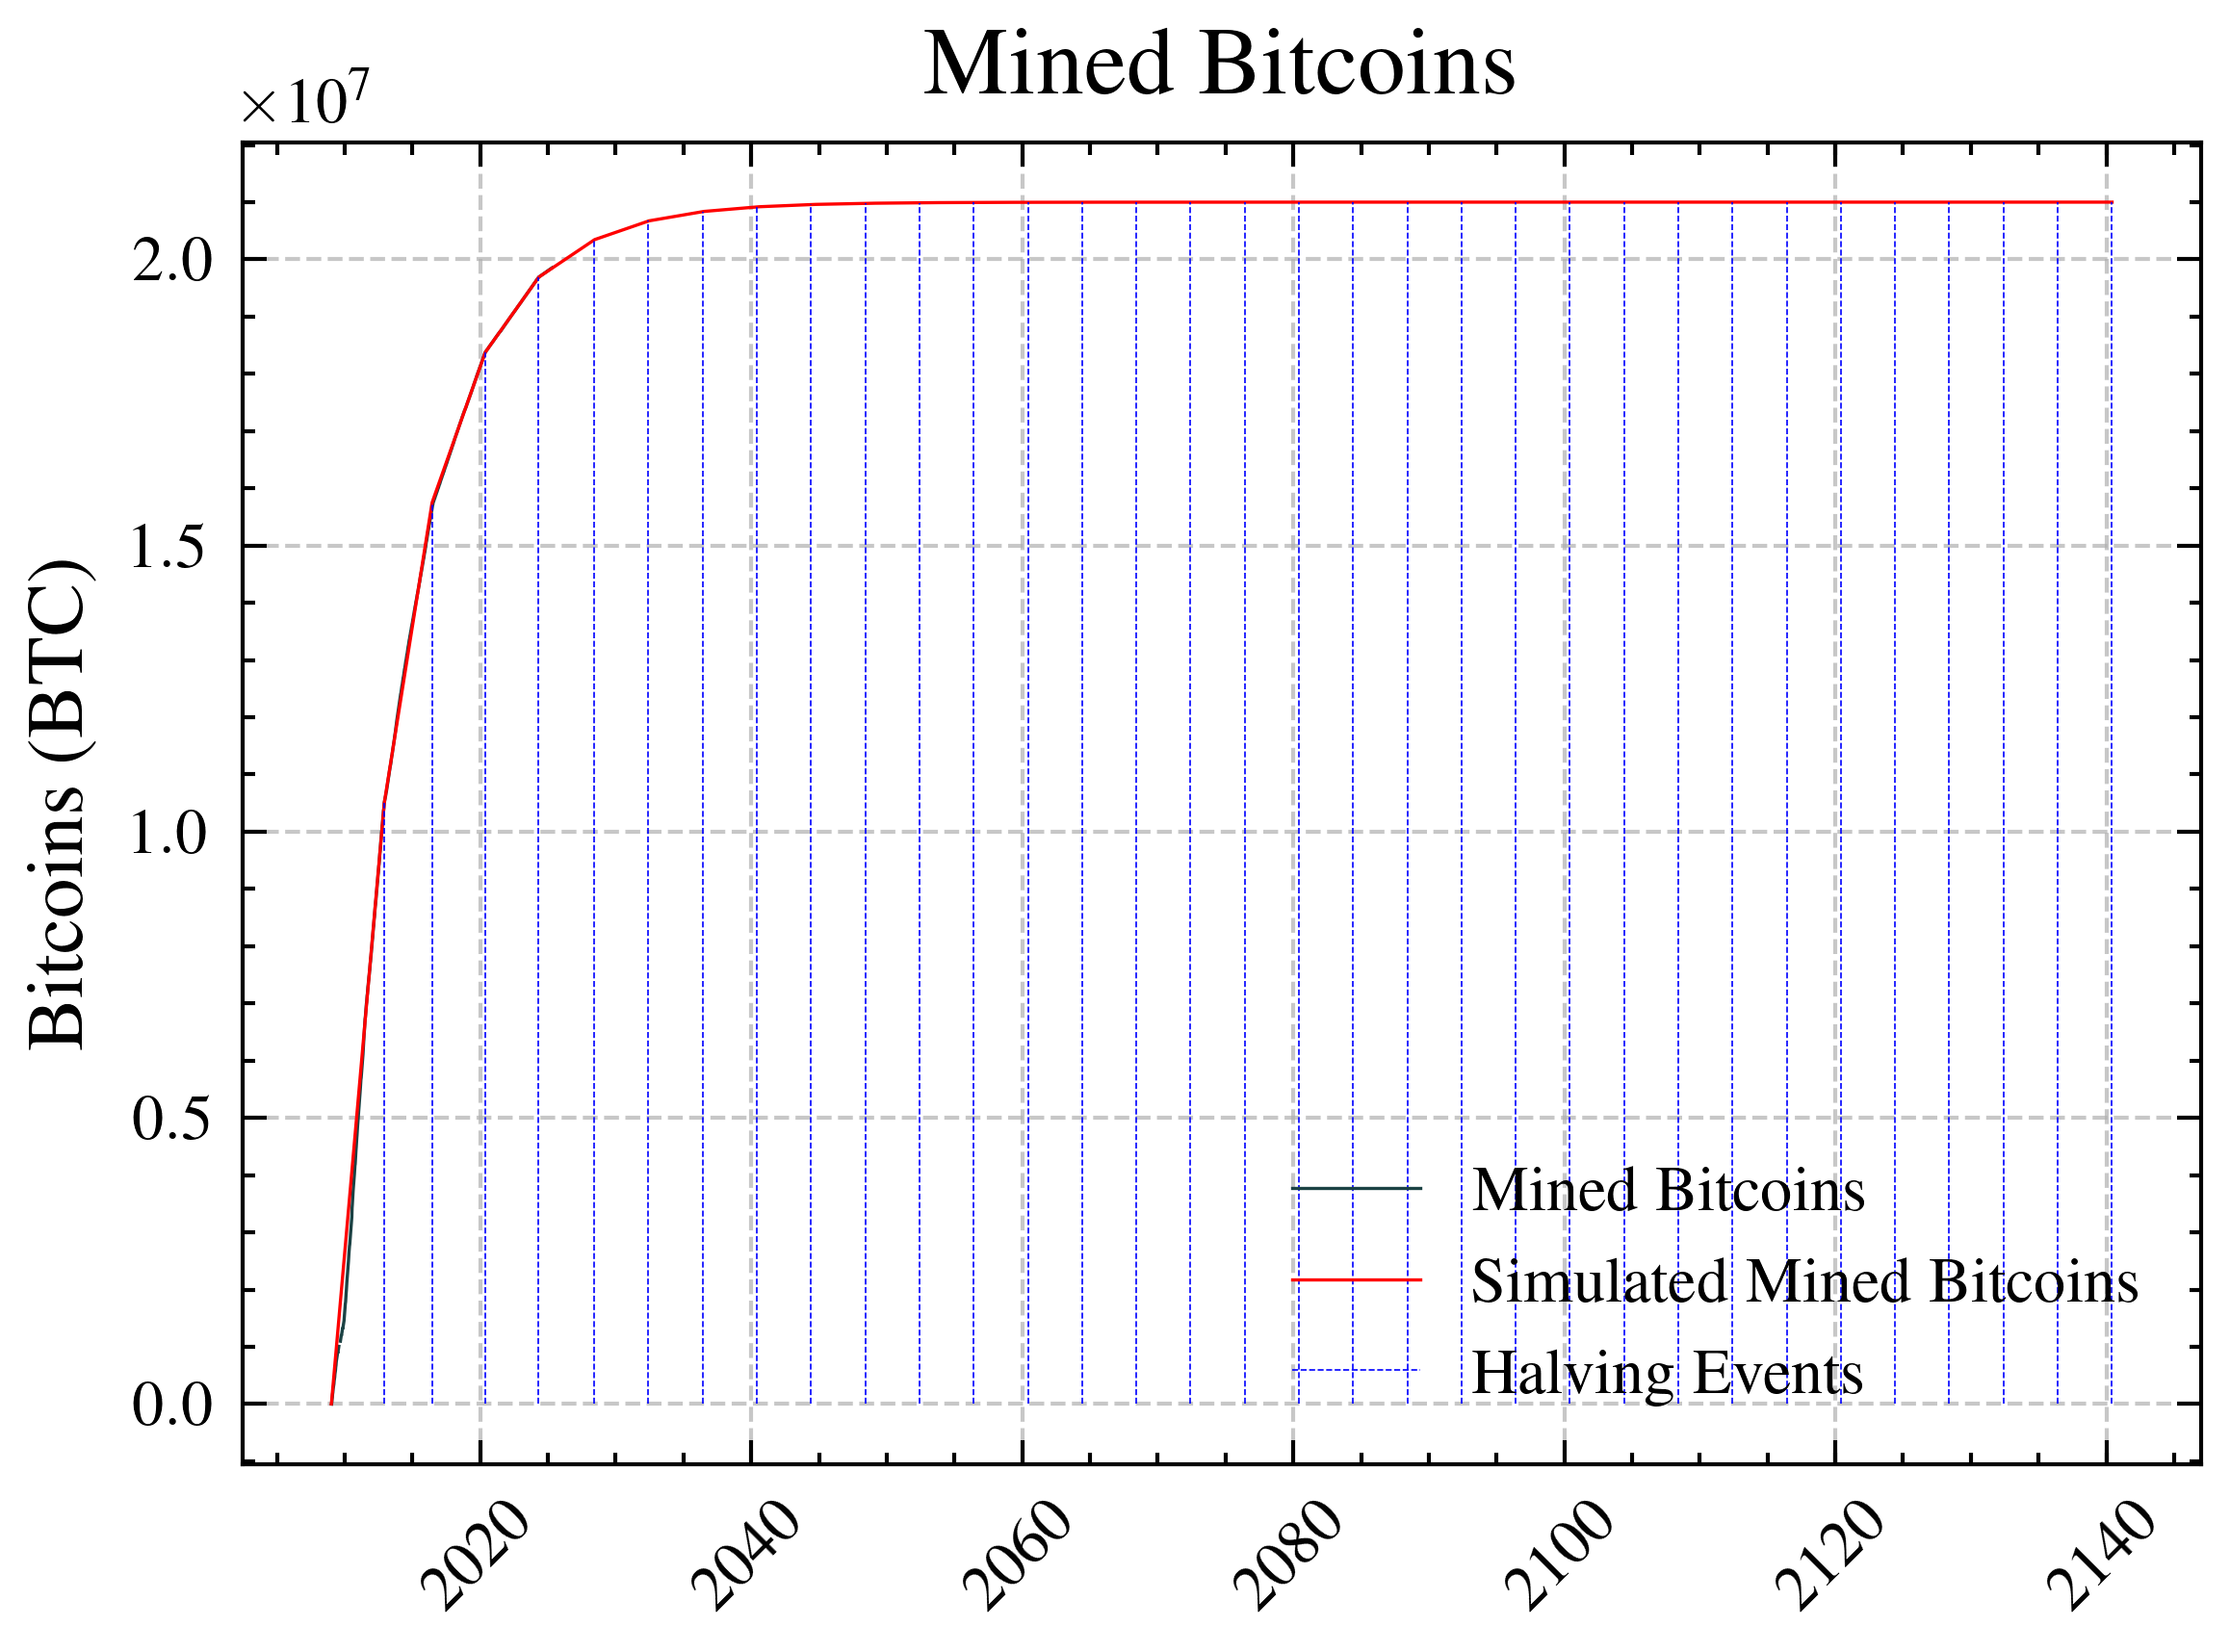

In [45]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 3))
    plt.plot(total_bitcoins_df.index, total_bitcoins_df['total_bitcoins'], label='Mined Bitcoins', linewidth=0.4, color=LINE_COLOR)
    plt.plot(sim_btc_res.index, sim_btc_res['Total BTC Mined'], 'r-', label='Simulated Mined Bitcoins' , linewidth=0.4)
    plt.vlines(sim_btc.index,0,sim_btc['Total BTC Mined'], colors='b', linestyles='dashed', label='Halving Events', linewidth=0.2)

    plt.title('Mined Bitcoins', fontsize=12)
    plt.ylabel('Bitcoins (BTC)', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add some padding to prevent label cutoff
    plt.tight_layout()
    plt.show()

In [46]:
future_bitcoins = sim_btc_res[total_bitcoins_df.index[-1]:][['Total BTC Mined']].rename(columns={'Total BTC Mined': 'total_bitcoins'})

In [47]:
delta = total_bitcoins_df["total_bitcoins"][-1]-future_bitcoins['total_bitcoins'][0]
total_bitcoins_df["total_bitcoins"][-1],future_bitcoins['total_bitcoins'][0]

C:\Users\pkapl\AppData\Local\Temp\ipykernel_18624\979905648.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta = total_bitcoins_df["total_bitcoins"][-1]-future_bitcoins['total_bitcoins'][0]
C:\Users\pkapl\AppData\Local\Temp\ipykernel_18624\979905648.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_bitcoins_df["total_bitcoins"][-1],future_bitcoins['total_bitcoins'][0]


(np.float64(19855423.4375), np.float64(19848615.269461077))

In [48]:
future_bitcoins['total_bitcoins'] = future_bitcoins['total_bitcoins']+delta

In [49]:
total_bitcoins_df["total_bitcoins"][-1],future_bitcoins['total_bitcoins'][0]

C:\Users\pkapl\AppData\Local\Temp\ipykernel_18624\1049246735.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_bitcoins_df["total_bitcoins"][-1],future_bitcoins['total_bitcoins'][0]


(np.float64(19855423.4375), np.float64(19855423.4375))

In [50]:
total_bitcoins_df = pd.concat([total_bitcoins_df, future_bitcoins[1:]], axis=0)

In [51]:
difff=sim_btc_res.diff()

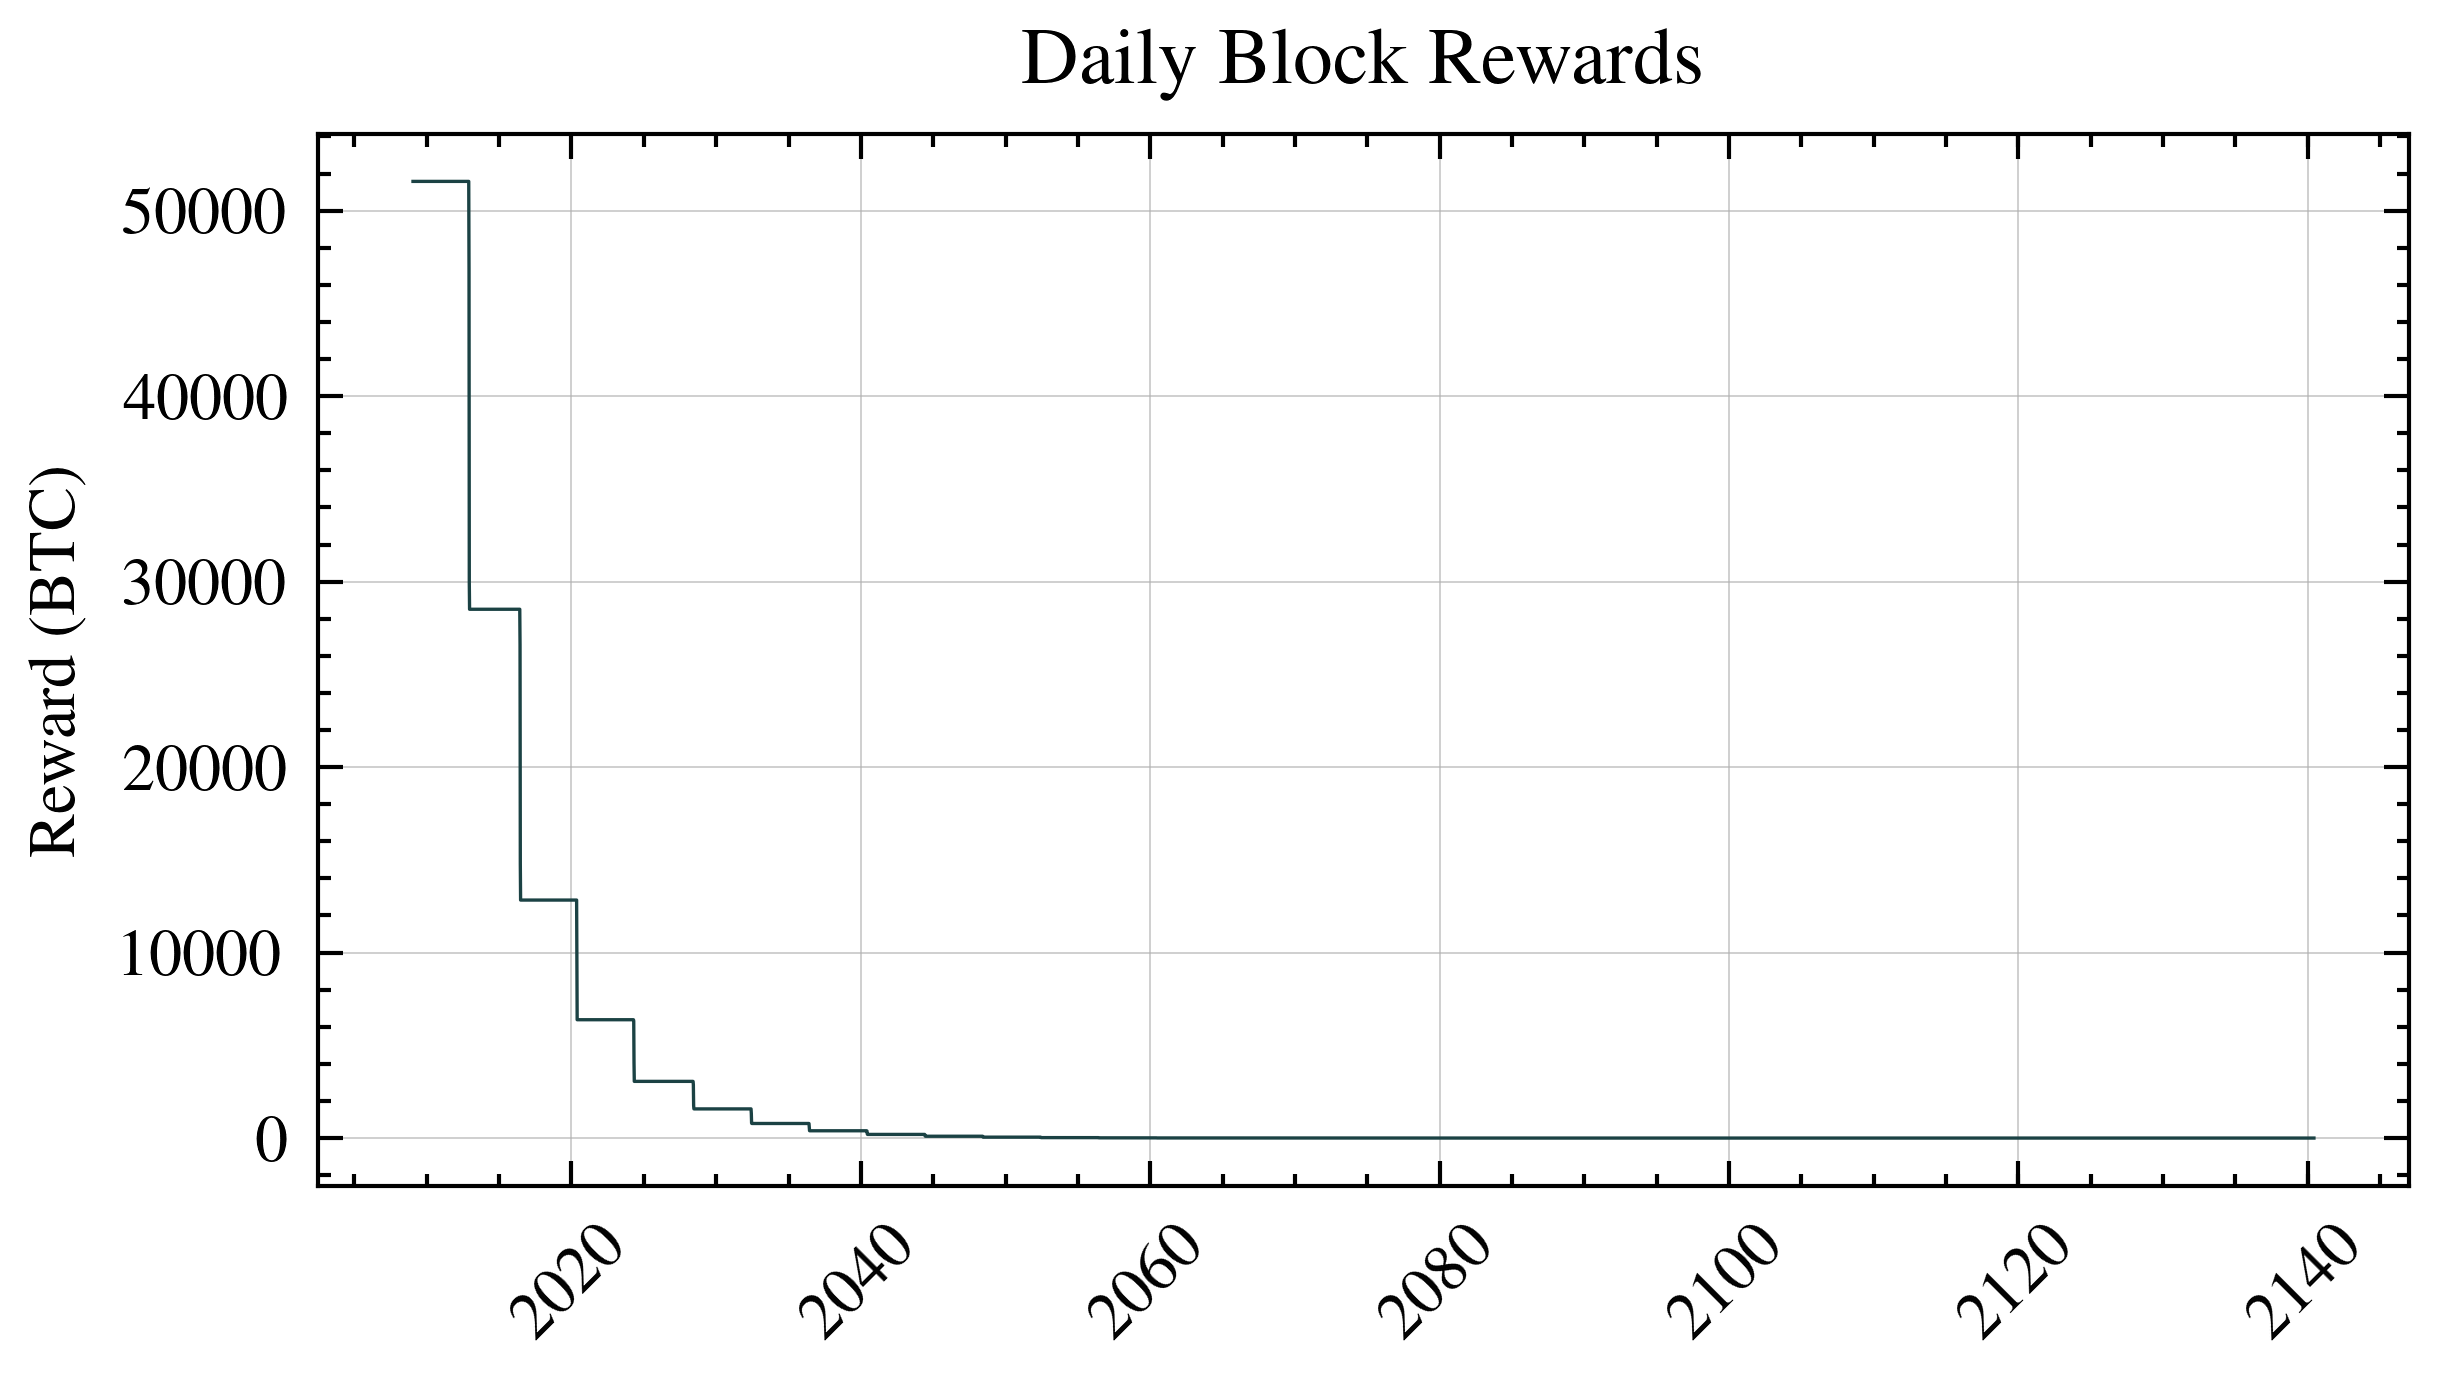

In [52]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(difff.index[2:], difff['Total BTC Mined'][2:], color=LINE_COLOR, linewidth=0.4)
    plt.ylabel('Reward (BTC)')
    plt.title('Daily Block Rewards')
    plt.savefig(ASSETS+'blockrewards1.png')
    plt.show()

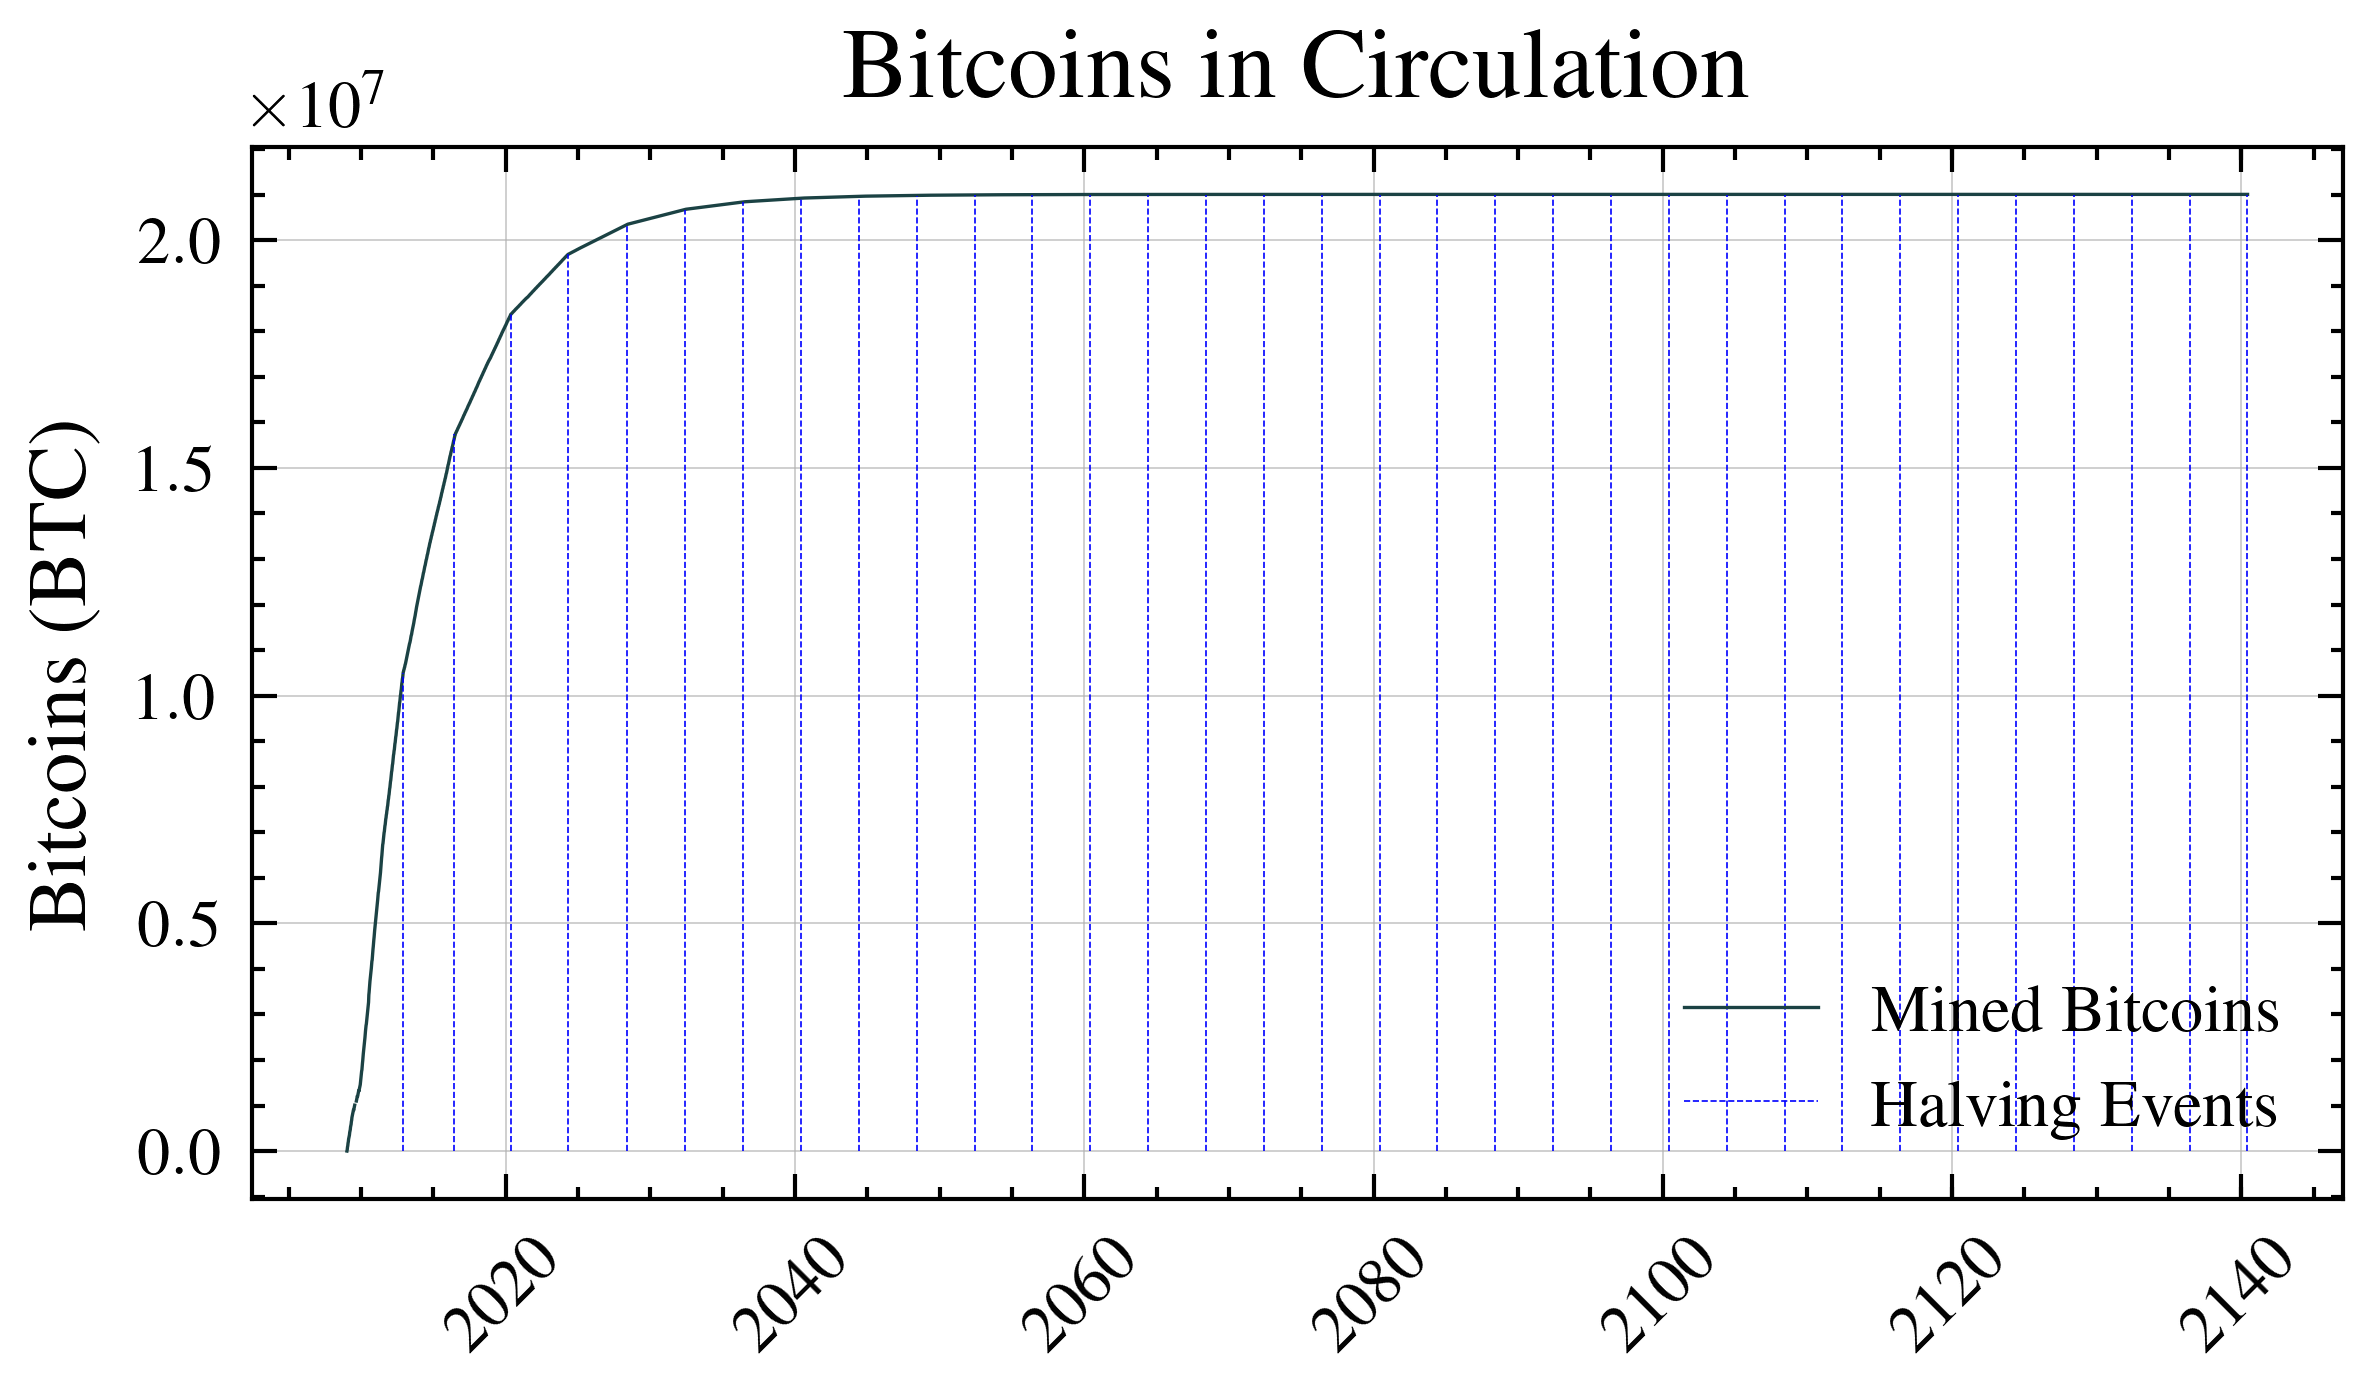

In [53]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(total_bitcoins_df.index, total_bitcoins_df['total_bitcoins'],color=LINE_COLOR, linewidth=0.4, label='Mined Bitcoins')
    plt.vlines(sim_btc.index,0,sim_btc['Total BTC Mined'], colors='b', linestyles='dashed', label='Halving Events', linewidth=0.2)
    plt.title('Bitcoins in Circulation', fontsize=12)
    plt.ylabel('Bitcoins (BTC)', fontsize=10)
    plt.legend()
    plt.savefig(ASSETS+'minedbitcoin1.png')
    plt.show()

In [54]:
total_bitcoins_df.to_csv(OUTPUT+'total_bitcoins.csv')